<a href="https://colab.research.google.com/github/HansDampf37/Kaggle/blob/main/Kaggle_Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [595]:
# !pip install shap
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Load and Prepare datasets
- We factorize features to numbers
- I suppose that Cabins with the same starting number are closer together -> we split *cabin* into the features *cabinNumber* an *cabinLetter*


In [596]:
labeled = pd.read_csv('data/train.csv')
unlabeled = pd.read_csv('data/test.csv')
labeled.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [597]:
def preprocess_data(data):
  data['CabinLetter'] = data['Cabin'].str.extract(r'([A-Za-z])', expand=False)
  data['CabinLetter'] = pd.factorize(data['CabinLetter'])[0]
  data['CabinNumber'] = data['Cabin'].str.extract(r'(\d+)', expand=False)
  data['CabinNumber'] = pd.to_numeric(data['CabinNumber'], errors='coerce')
  data['Sex'] = pd.factorize(data['Sex'])[0]
  # data['Ticket'] = pd.factorize(data['Ticket'])[0]
  data['Embarked'] = pd.factorize(data['Embarked'])[0]
  data.fillna(-1, inplace=True)
  data.drop(columns=['Name', 'Cabin', 'Ticket', 'PassengerId'], inplace=True)


y = labeled['Survived']
X = labeled.drop(columns=["Survived"])
preprocess_data(X)
preprocess_data(unlabeled)

X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinLetter,CabinNumber
0,3,0,22.0,1,0,7.2500,0,-1,-1.0
1,1,1,38.0,1,0,71.2833,1,0,85.0
2,3,1,26.0,0,0,7.9250,0,-1,-1.0
3,1,1,35.0,1,0,53.1000,0,0,123.0
4,3,0,35.0,0,0,8.0500,0,-1,-1.0


# Train a simple SVM to compare against

In [598]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")


svc = SVC(probability=True, random_state=42)
svc.fit(X_train, y_train)
print(f'SVC Training Accuracy: {svc.score(X_train, y_train)}')
print(f'SVC Test Accuracy: {svc.score(X_test, y_test)}')

rfc = RandomForestClassifier(random_state=42, n_estimators=100)
rfc.fit(X_train, y_train)
print(f'RFC Training Accuracy: {rfc.score(X_train, y_train)}')
print(f'RFC Test Accuracy: {rfc.score(X_test, y_test)}')

Train size: 801
Test size: 90
SVC Training Accuracy: 0.6928838951310862
SVC Test Accuracy: 0.7444444444444445
RFC Training Accuracy: 0.9850187265917603
RFC Test Accuracy: 0.8111111111111111


# Implement a model

Implement a classifier model

In [599]:
class Classifier(nn.Module):
  def __init__(self, input_size, output_size):
    super(Classifier, self).__init__()
    self.fc1 = nn.Linear(input_size, 16)
    self.fc2 = nn.Linear(16, 16)
    self.fc3 = nn.Linear(16, 16)
    self.fc4 = nn.Linear(16, output_size)
    self.relu = nn.ReLU()
    self.optimizer = optim.Adam(self.parameters(), lr=0.001)
    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.fc4(x)
    return x

model = Classifier(X_train.shape[1], 2) # Assuming binary classification (Survived or not)
summary(model, (1, X_train.shape[1])) # Adjust input shape for summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]             160
              ReLU-2                [-1, 1, 16]               0
            Linear-3                [-1, 1, 16]             272
              ReLU-4                [-1, 1, 16]               0
            Linear-5                [-1, 1, 16]             272
              ReLU-6                [-1, 1, 16]               0
            Linear-7                 [-1, 1, 2]              34
Total params: 738
Trainable params: 738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Train it

Epoch [1/400], Loss: 0.7318, Accuracy: 65.67%, Test Accuracy: 74.44
Epoch [2/400], Loss: 0.4236, Accuracy: 68.29%, Test Accuracy: 74.44
Epoch [3/400], Loss: 0.4579, Accuracy: 69.29%, Test Accuracy: 73.33
Epoch [4/400], Loss: 0.2278, Accuracy: 70.16%, Test Accuracy: 74.44
Epoch [5/400], Loss: 0.6331, Accuracy: 70.29%, Test Accuracy: 75.56
Epoch [6/400], Loss: 0.1051, Accuracy: 70.41%, Test Accuracy: 75.56
Epoch [7/400], Loss: 0.7737, Accuracy: 69.29%, Test Accuracy: 77.78
Epoch [8/400], Loss: 0.7250, Accuracy: 69.66%, Test Accuracy: 76.67
Epoch [9/400], Loss: 0.7902, Accuracy: 72.41%, Test Accuracy: 78.89
Epoch [10/400], Loss: 0.3255, Accuracy: 74.03%, Test Accuracy: 77.78
Epoch [11/400], Loss: 1.1806, Accuracy: 74.66%, Test Accuracy: 84.44
Epoch [12/400], Loss: 0.0617, Accuracy: 75.66%, Test Accuracy: 78.89
Epoch [13/400], Loss: 0.0901, Accuracy: 76.90%, Test Accuracy: 83.33
Epoch [14/400], Loss: 1.1294, Accuracy: 78.28%, Test Accuracy: 78.89
Epoch [15/400], Loss: 0.3421, Accuracy: 76.

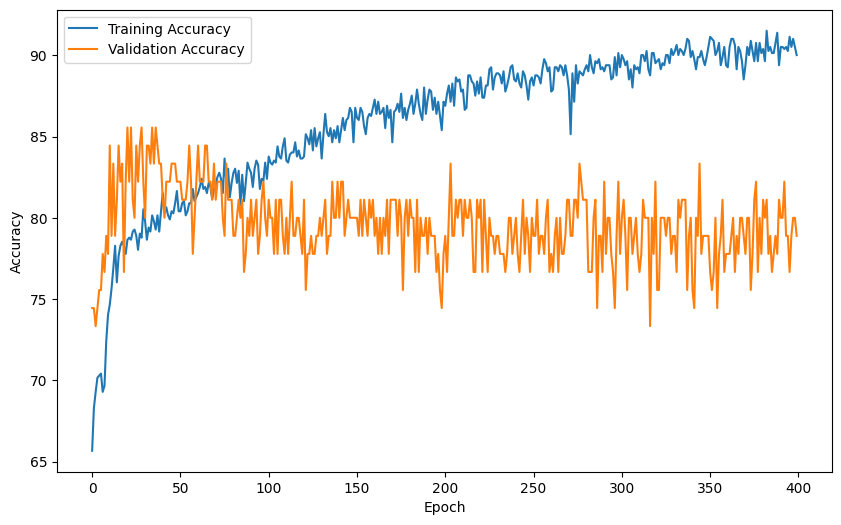

In [600]:
# Convert Pandas Series to PyTorch tensors
train_X_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
train_y_tensor = torch.tensor(y_train.values, dtype=torch.long)
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

valid_X_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)
valid_y_tensor = torch.tensor(y_test.values, dtype=torch.long)
valid_dataset = TensorDataset(valid_X_tensor, valid_y_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=False)

def evaluate_test_accuracy(model, test_loader):
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation for test
        val_correct = 0
        val_samples = 0
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == batch_y).sum().item()
            val_samples += batch_y.size(0)

        val_accuracy = 100 * val_correct / val_samples
    model.train() # Set model back to training mode
    return val_accuracy

def train(model, train_loader, test_loader, num_epochs = 400):
  model.train()
  training_accuracies = []
  test_accuracies = []
  for epoch in range(num_epochs):
      total_correct = 0
      total_samples = 0
      for batch_X, batch_y in train_loader:
          # Forward pass
          outputs = model(batch_X)
          loss = model.loss_fn(outputs, batch_y)

          # Backward pass and optimization
          model.optimizer.zero_grad()
          loss.backward()
          model.optimizer.step()

          # Accuracy calculation
          _, predicted = torch.max(outputs, 1)  # Get predicted class indices
          total_correct += (predicted == batch_y).sum().item()
          total_samples += batch_y.size(0)

      accuracy = 100 * total_correct / total_samples
      test_accuracy = evaluate_test_accuracy(model, test_loader) if test_loader is not None else 0
      training_accuracies.append(accuracy)
      test_accuracies.append(test_accuracy)

      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}')
  return training_accuracies, test_accuracies


def plot(training_accuracies, test_accuracies):
  plt.figure(figsize=(10, 6))
  plt.plot(training_accuracies, label='Training Accuracy')
  plt.plot(test_accuracies, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

training_accuracies, test_accuracies = train(model, train_loader, valid_loader)
plot(training_accuracies, test_accuracies)

# Explain predictions with SHAP
As my model requires tensors as input and SHAP requires np arrays, I introduced a model_wrapper, that transforms incoming data to a tensor.

In [601]:
def explain(model, data):
  def model_wrapper(data):
      # Transform data to tensor
      data_tensor = torch.tensor(data, dtype=torch.float32)
      with torch.no_grad():
          # Run the model and convert the output back to NumPy array
          return model(data_tensor).numpy()

  explainer = shap.KernelExplainer(model_wrapper, data)
  return explainer(X_test)

background_indices = np.random.choice(X_train.shape[0], 50, replace=False)
background = X_train.iloc[background_indices]
shap_values = explain(model, background)

  0%|          | 0/90 [00:00<?, ?it/s]

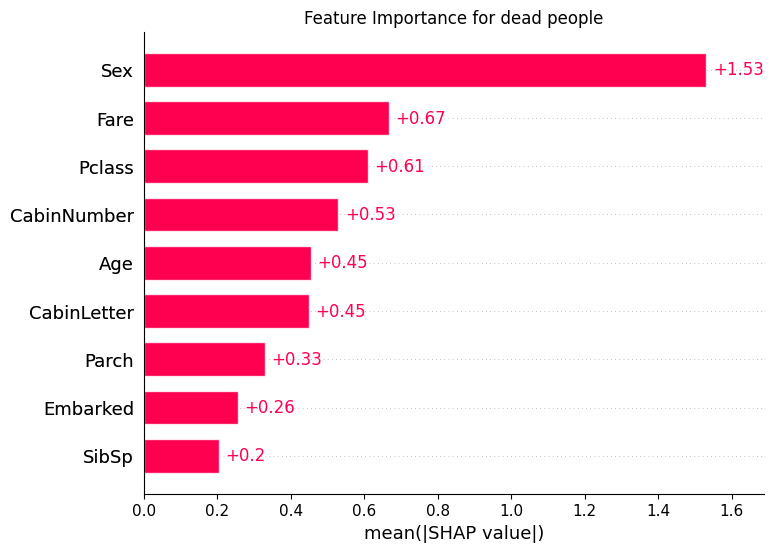

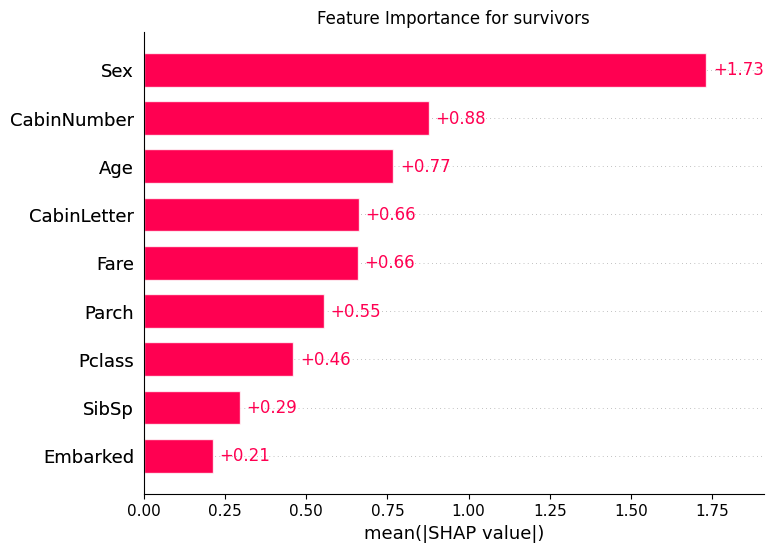

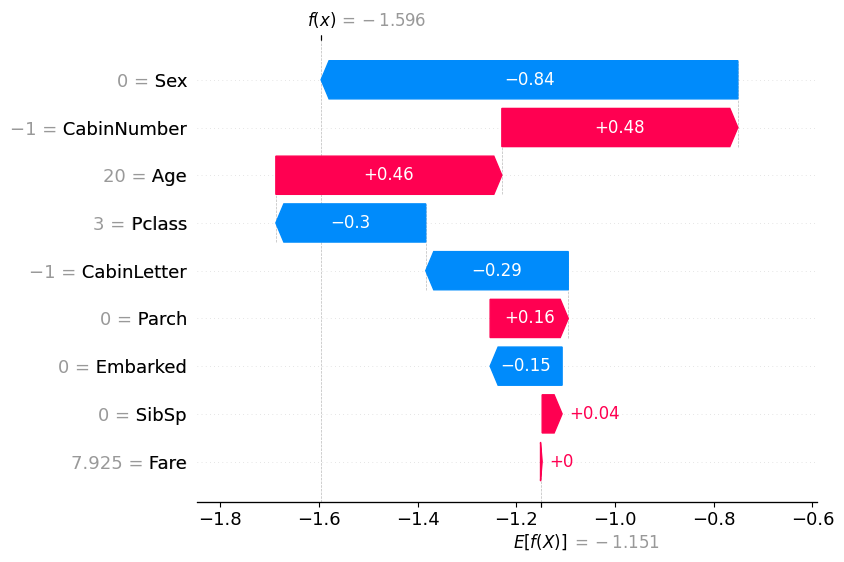

In [602]:
def plot_shap(shap_values):
  plt.title("Feature Importance for dead people")
  shap.plots.bar(shap_values[:, :, 0])
  plt.title("Feature Importance for survivors")
  shap.plots.bar(shap_values[:, :, 1])
  shap.plots.waterfall(shap_values[2, :, 1])

plot_shap(shap_values)

# Ensemble
Try to get better predictions by aggregating predictions about relationships, position, and the person itself.

Epoch [1/100], Loss: 0.5106, Accuracy: 58.18%, Test Accuracy: 60.00
Epoch [2/100], Loss: 0.5903, Accuracy: 61.92%, Test Accuracy: 60.00
Epoch [3/100], Loss: 0.8450, Accuracy: 61.92%, Test Accuracy: 60.00
Epoch [4/100], Loss: 0.8099, Accuracy: 62.17%, Test Accuracy: 74.44
Epoch [5/100], Loss: 0.5431, Accuracy: 69.04%, Test Accuracy: 77.78
Epoch [6/100], Loss: 0.1473, Accuracy: 71.54%, Test Accuracy: 80.00
Epoch [7/100], Loss: 0.7812, Accuracy: 78.15%, Test Accuracy: 81.11
Epoch [8/100], Loss: 1.7629, Accuracy: 79.78%, Test Accuracy: 80.00
Epoch [9/100], Loss: 0.2290, Accuracy: 79.90%, Test Accuracy: 82.22
Epoch [10/100], Loss: 0.1877, Accuracy: 79.65%, Test Accuracy: 82.22
Epoch [11/100], Loss: 0.3050, Accuracy: 79.90%, Test Accuracy: 81.11
Epoch [12/100], Loss: 1.9013, Accuracy: 79.90%, Test Accuracy: 81.11
Epoch [13/100], Loss: 0.2224, Accuracy: 79.53%, Test Accuracy: 81.11
Epoch [14/100], Loss: 0.1805, Accuracy: 79.90%, Test Accuracy: 81.11
Epoch [15/100], Loss: 1.8507, Accuracy: 80.

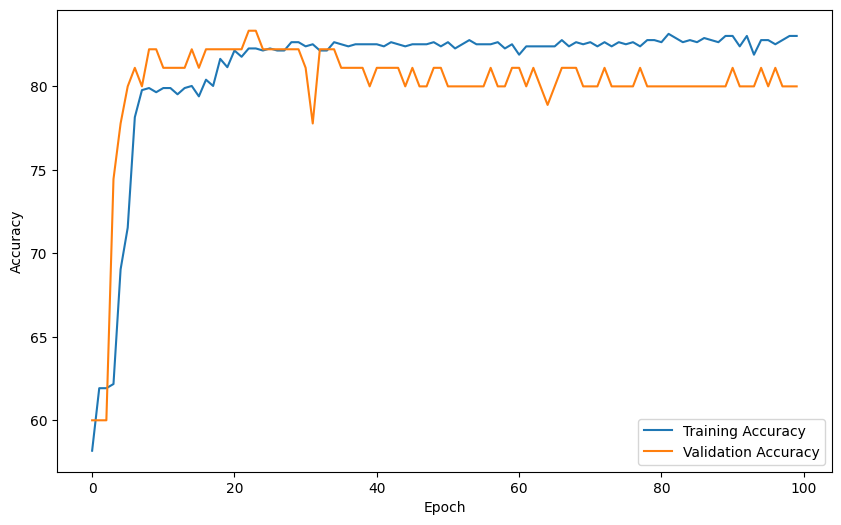

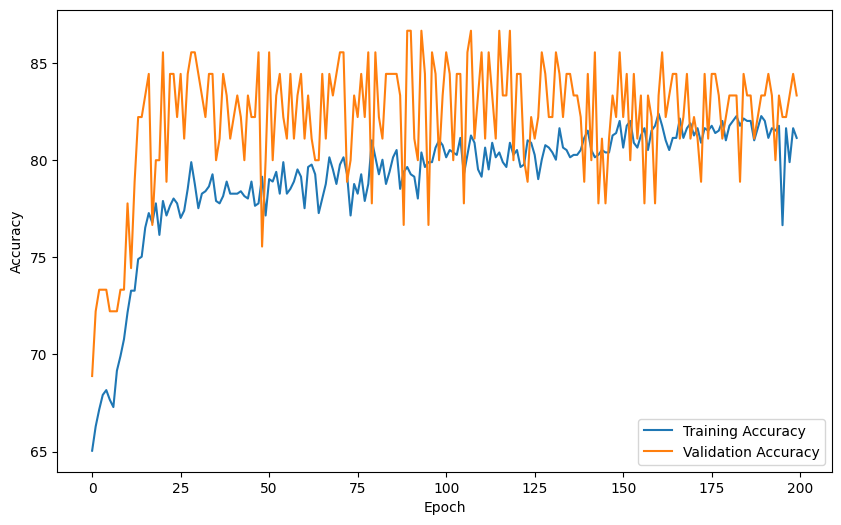

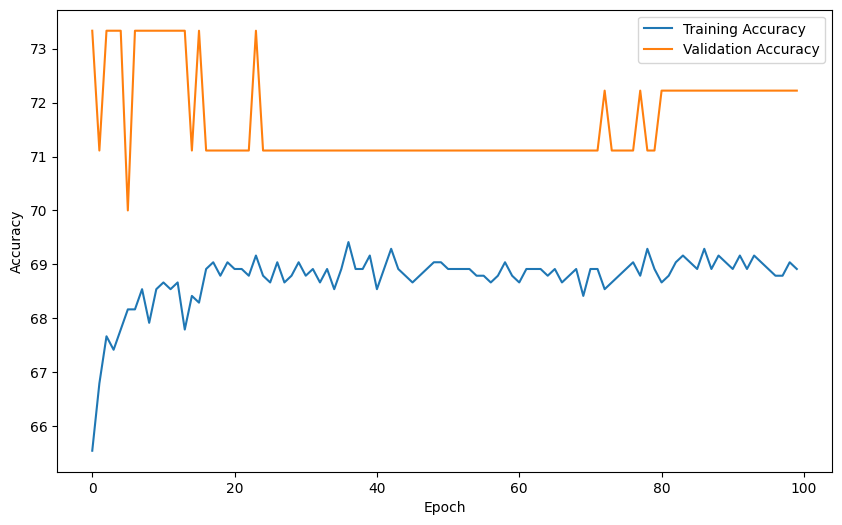

In [603]:
def split(data, location_columns, relationship_columns, personal_columns):
  X_train_relationships = data[relationship_columns]
  X_train_personal = data[personal_columns]
  X_train_loc = data[location_columns]
  relationship_columns_indices = [data.columns.get_loc(col) for col in relationship_columns]
  personal_columns_indices = [data.columns.get_loc(col) for col in personal_columns]
  location_columns_indices = [data.columns.get_loc(col) for col in location_columns]

  return X_train_relationships, X_train_personal, X_train_loc, relationship_columns_indices, personal_columns_indices, location_columns_indices

def get_models(location_columns, relationship_columns, personal_columns):
  split_data = split(X_train, location_columns, relationship_columns, personal_columns)
  X_train_relationships, X_train_personal, X_train_loc, relationship_columns_indices, personal_columns_indices, location_columns_indices = split_data

  split_data = split(X_test, location_columns, relationship_columns, personal_columns)
  X_test_relationships, X_test_personal, X_test_loc, _, _, _ = split_data

  relationship_model = Classifier(X_train_relationships.shape[1], 2)
  personal_model = Classifier(X_train_personal.shape[1], 2)
  loc_model = Classifier(X_train_loc.shape[1], 2)

  relationship_dataset = TensorDataset(torch.tensor(X_train_relationships.values.astype(np.float32), dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
  relationship_loader = DataLoader(relationship_dataset, batch_size=10, shuffle=True)
  relationship_test_dataset = TensorDataset(torch.tensor(X_test_relationships.values.astype(np.float32), dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))
  relationship_test_loader = DataLoader(relationship_test_dataset, batch_size=10, shuffle=False)
  personal_dataset = TensorDataset(torch.tensor(X_train_personal.values.astype(np.float32), dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
  personal_loader = DataLoader(personal_dataset, batch_size=10, shuffle=True)
  personal_test_dataset = TensorDataset(torch.tensor(X_test_personal.values.astype(np.float32), dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))
  personal_test_loader = DataLoader(personal_test_dataset, batch_size=10, shuffle=False)
  loc_dataset = TensorDataset(torch.tensor(X_train_loc.values.astype(np.float32), dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
  loc_loader = DataLoader(loc_dataset, batch_size=10, shuffle=True)
  loc_test_dataset = TensorDataset(torch.tensor(X_test_loc.values.astype(np.float32), dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))
  loc_test_loader = DataLoader(loc_test_dataset, batch_size=10, shuffle=False)

  a_rel, b_rel = train(relationship_model, relationship_loader, relationship_test_loader, 100)
  a_pers, b_pers = train(personal_model, personal_loader, personal_test_loader, 200)
  a_loc, b_loc = train(loc_model, loc_loader, loc_test_loader, 100)
  plot(a_rel, b_rel)
  plot(a_pers, b_pers)
  plot(a_loc, b_loc)

  return loc_model, relationship_model, personal_model, location_columns_indices, relationship_columns_indices, personal_columns_indices


loc_columns = ['Pclass', 'CabinNumber', 'CabinLetter', 'Embarked']
rel_columns = ['SibSp', 'Parch', 'Age', 'Sex']
pers_columns = ['Age', 'Sex', 'Pclass', 'Fare']
split_data = get_models(loc_columns, rel_columns, pers_columns)
loc_model, relationship_model, personal_model, location_columns_indices, relationship_columns_indices, personal_columns_indices = split_data

Epoch [1/100], Loss: 0.1874, Accuracy: 82.77%, Test Accuracy: 81.11
Epoch [2/100], Loss: 0.0554, Accuracy: 83.02%, Test Accuracy: 81.11
Epoch [3/100], Loss: 0.2871, Accuracy: 83.02%, Test Accuracy: 81.11
Epoch [4/100], Loss: 0.0742, Accuracy: 83.40%, Test Accuracy: 80.00
Epoch [5/100], Loss: 0.7345, Accuracy: 83.40%, Test Accuracy: 81.11
Epoch [6/100], Loss: 1.8939, Accuracy: 84.39%, Test Accuracy: 80.00
Epoch [7/100], Loss: 0.0893, Accuracy: 83.27%, Test Accuracy: 78.89
Epoch [8/100], Loss: 0.0665, Accuracy: 83.52%, Test Accuracy: 81.11
Epoch [9/100], Loss: 1.2242, Accuracy: 83.77%, Test Accuracy: 82.22
Epoch [10/100], Loss: 0.0328, Accuracy: 84.14%, Test Accuracy: 80.00
Epoch [11/100], Loss: 0.1455, Accuracy: 84.39%, Test Accuracy: 81.11
Epoch [12/100], Loss: 0.4477, Accuracy: 82.90%, Test Accuracy: 81.11
Epoch [13/100], Loss: 0.1272, Accuracy: 83.52%, Test Accuracy: 80.00
Epoch [14/100], Loss: 0.0539, Accuracy: 84.39%, Test Accuracy: 81.11
Epoch [15/100], Loss: 0.7011, Accuracy: 83.

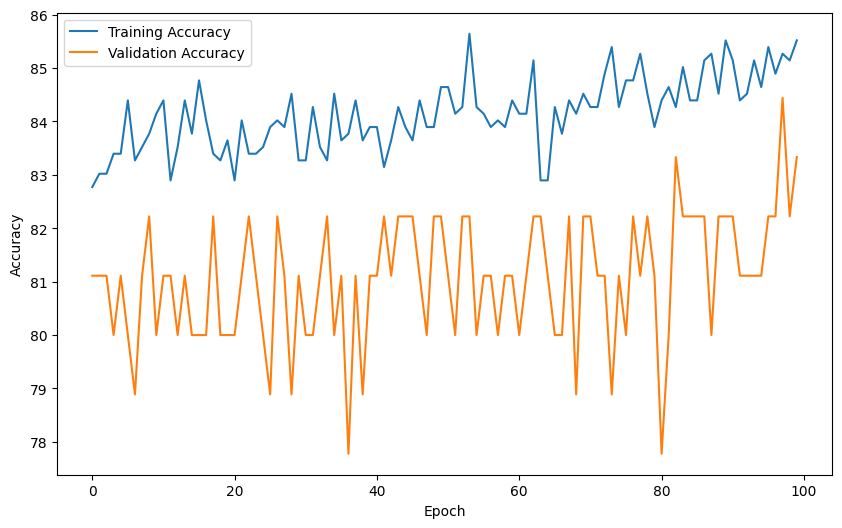

In [604]:
class EnsembleModel(nn.Module):
  def __init__(self, loc_model, relationship_model, personal_model, loc_indices, rel_indices, pers_indices):
    super(EnsembleModel, self).__init__()
    self.loc_model = loc_model
    self.relationship_model = relationship_model
    self.personal_model = personal_model
    self.rel_indices = rel_indices
    self.pers_indices = pers_indices
    self.loc_indices = loc_indices
    self.x = nn.Parameter(torch.randn(1, 2))
    self.y = nn.Parameter(torch.randn(1, 2))
    self.z = nn.Parameter(torch.randn(1, 2))
    self.loss_fn = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.parameters(), lr=0.001)

  def forward(self, x):
    loc_output = self.x * self.loc_model(x[:, self.loc_indices])
    relationship_output = self.y * self.relationship_model(x[:, self.rel_indices])
    personal_output = self.z * self.personal_model(x[:, self.pers_indices])
    return (loc_output + relationship_output + personal_output) / (self.x + self.y + self.z)

ensemble_model = EnsembleModel(
  loc_model,
  relationship_model,
  personal_model,
  location_columns_indices,
  relationship_columns_indices,
  personal_columns_indices
)
a, b = train(ensemble_model, train_loader, valid_loader, 100)
plot(a, b)

In [605]:
print(f"FF Model: {evaluate_test_accuracy(model, valid_loader)}")
print(f"Ensemble: {evaluate_test_accuracy(ensemble_model, valid_loader)}")

FF Model: 78.88888888888889
Ensemble: 83.33333333333333


# Revisit Data for additional features
I joined the following features into the data:
- Title: Mrs, Mr, Dr, ...
- Ticket Number & Prefix
- Cabin Number & Letter

The standard classifier does not perform well under these conditions as the causaility between the new features is too sparse.

So I focused on examining the Ensembles performance with these new features.

In [606]:
labeled = pd.read_csv('data/train.csv')
unlabeled = pd.read_csv('data/test.csv')
labeled.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [607]:
def preprocess_data_feature_engineering(data):
  data['CabinLetter'] = data['Cabin'].str.extract(r'([A-Za-z])', expand=False)
  data['CabinNumber'] = data['Cabin'].str.extract(r'(\d+)', expand=False)
  data['Title'] = data['Name'].apply(extract_title)
  data['TicketPrefix'] = data['Ticket'].apply(lambda x: x.split()[0] if len(x.split()) > 1 else None)
  data['TicketNumber'] = data['Ticket'].apply(lambda x: x.split()[-1])

  data['CabinLetter'] = pd.factorize(data['CabinLetter'])[0]
  data['CabinNumber'] = pd.to_numeric(data['CabinNumber'], errors='coerce')
  data['Sex'] = pd.factorize(data['Sex'])[0]
  data['Title'] = pd.factorize(data['Title'])[0]
  data['TicketPrefix'] = pd.factorize(data['TicketPrefix'])[0]
  data['TicketNumber'] = pd.to_numeric(data['TicketNumber'], errors='coerce')
  data['Embarked'] = pd.factorize(data['Embarked'])[0]
  data.fillna(-1, inplace=True)
  data.drop(columns=['Name', 'Cabin', 'Ticket', 'PassengerId'], inplace=True)

def extract_title(name):
    title = name.split(',')[1].split('.')[0].strip()
    return title

y = labeled['Survived']
X = labeled.drop(columns=["Survived"])
preprocess_data_feature_engineering(X)
passengerIDs = unlabeled['PassengerId']
preprocess_data_feature_engineering(unlabeled)
unlabeled['PassengerId'] = passengerIDs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

train_X_tensor_new = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
train_y_tensor_new = torch.tensor(y_train.values, dtype=torch.long)
train_dataset_new = TensorDataset(train_X_tensor_new, train_y_tensor_new)
train_loader_new = DataLoader(train_dataset_new, batch_size=10, shuffle=True)

valid_X_tensor_new = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)
valid_y_tensor_new = torch.tensor(y_test.values, dtype=torch.long)
valid_dataset_new = TensorDataset(valid_X_tensor_new, valid_y_tensor_new)
valid_loader_new = DataLoader(valid_dataset_new, batch_size=10, shuffle=False)

X.head()

Train size: 801
Test size: 90


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinLetter,CabinNumber,Title,TicketPrefix,TicketNumber
0,3,0,22.0,1,0,7.2500,0,-1,-1.0,0,0,21171.0
1,1,1,38.0,1,0,71.2833,1,0,85.0,1,1,17599.0
2,3,1,26.0,0,0,7.9250,0,-1,-1.0,2,2,3101282.0
3,1,1,35.0,1,0,53.1000,0,0,123.0,1,-1,113803.0
4,3,0,35.0,0,0,8.0500,0,-1,-1.0,0,-1,373450.0


Epoch [1/100], Loss: 0.4659, Accuracy: 65.29%, Test Accuracy: 71.11
Epoch [2/100], Loss: 0.6784, Accuracy: 66.54%, Test Accuracy: 72.22
Epoch [3/100], Loss: 0.4686, Accuracy: 68.04%, Test Accuracy: 70.00
Epoch [4/100], Loss: 0.7558, Accuracy: 67.67%, Test Accuracy: 70.00
Epoch [5/100], Loss: 0.7729, Accuracy: 69.04%, Test Accuracy: 70.00
Epoch [6/100], Loss: 0.7079, Accuracy: 70.54%, Test Accuracy: 80.00
Epoch [7/100], Loss: 0.3668, Accuracy: 73.28%, Test Accuracy: 80.00
Epoch [8/100], Loss: 2.0332, Accuracy: 74.03%, Test Accuracy: 80.00
Epoch [9/100], Loss: 0.2069, Accuracy: 73.03%, Test Accuracy: 74.44
Epoch [10/100], Loss: 3.2157, Accuracy: 76.65%, Test Accuracy: 80.00
Epoch [11/100], Loss: 1.9881, Accuracy: 74.78%, Test Accuracy: 76.67
Epoch [12/100], Loss: 0.0488, Accuracy: 76.53%, Test Accuracy: 82.22
Epoch [13/100], Loss: 0.5164, Accuracy: 76.40%, Test Accuracy: 76.67
Epoch [14/100], Loss: 0.1219, Accuracy: 76.53%, Test Accuracy: 75.56
Epoch [15/100], Loss: 0.1374, Accuracy: 77.

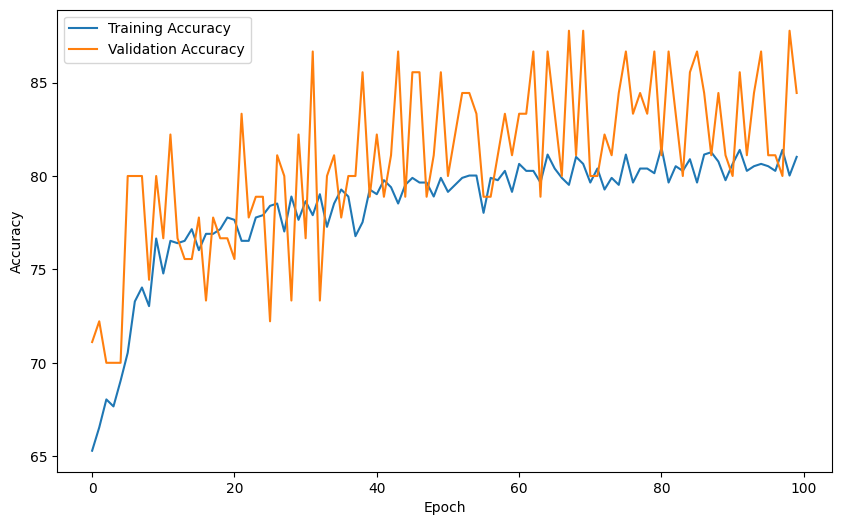

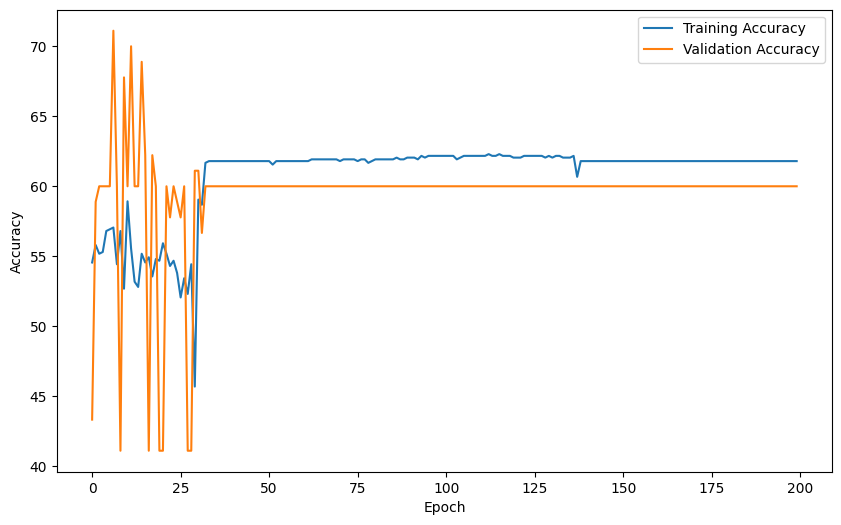

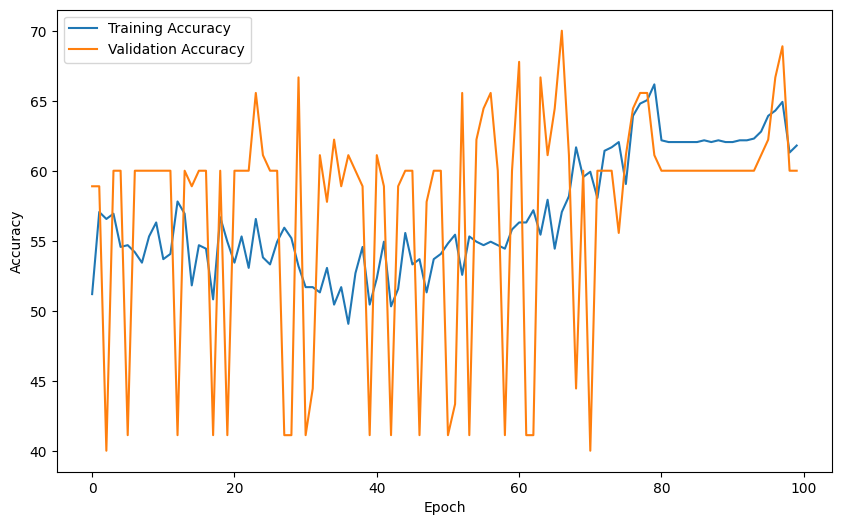

Epoch [1/100], Loss: 2.2118, Accuracy: 80.15%, Test Accuracy: 87.78
Epoch [2/100], Loss: 0.1934, Accuracy: 80.90%, Test Accuracy: 86.67
Epoch [3/100], Loss: 0.2436, Accuracy: 80.52%, Test Accuracy: 85.56
Epoch [4/100], Loss: 0.3817, Accuracy: 81.27%, Test Accuracy: 84.44
Epoch [5/100], Loss: 0.1695, Accuracy: 81.27%, Test Accuracy: 84.44
Epoch [6/100], Loss: 0.0842, Accuracy: 80.77%, Test Accuracy: 88.89
Epoch [7/100], Loss: 0.1115, Accuracy: 81.15%, Test Accuracy: 88.89
Epoch [8/100], Loss: 1.1241, Accuracy: 80.90%, Test Accuracy: 82.22
Epoch [9/100], Loss: 0.0790, Accuracy: 80.77%, Test Accuracy: 83.33
Epoch [10/100], Loss: 0.0736, Accuracy: 80.02%, Test Accuracy: 83.33
Epoch [11/100], Loss: 0.1401, Accuracy: 81.15%, Test Accuracy: 82.22
Epoch [12/100], Loss: 0.8465, Accuracy: 81.40%, Test Accuracy: 82.22
Epoch [13/100], Loss: 0.0786, Accuracy: 81.15%, Test Accuracy: 84.44
Epoch [14/100], Loss: 0.1713, Accuracy: 81.27%, Test Accuracy: 81.11
Epoch [15/100], Loss: 0.0004, Accuracy: 80.

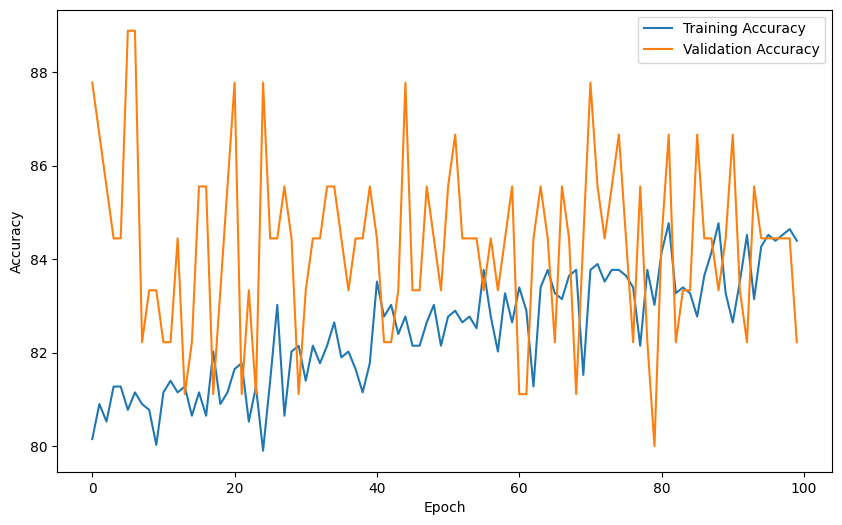

In [608]:
loc_columns = ['Pclass', 'CabinNumber', 'CabinLetter', 'Embarked', 'TicketPrefix', 'TicketNumber']
rel_columns = ['SibSp', 'Parch', 'Age', 'Sex', 'Title']
pers_columns = ['Age', 'Sex', 'Pclass', 'Fare', 'Title']

split_data = get_models(loc_columns, pers_columns, loc_columns)
loc_model2, relationship_model2, personal_model2, location_columns_indices2, relationship_columns_indices2, personal_columns_indices2 = split_data

ensemble_model_new = EnsembleModel(
    loc_model2,
    relationship_model2,
    personal_model2,
    location_columns_indices2,
    relationship_columns_indices2,
    personal_columns_indices2,
  )
a, b = train(ensemble_model_new, train_loader_new, valid_loader_new, 100)
plot(a, b)

In [609]:
print(f"FF Model: {evaluate_test_accuracy(model, valid_loader)}")
print(f"Old Ensemble: {evaluate_test_accuracy(ensemble_model, valid_loader)}")
print(f"New Ensemble: {evaluate_test_accuracy(ensemble_model_new, valid_loader_new)}")

FF Model: 78.88888888888889
Old Ensemble: 83.33333333333333
New Ensemble: 82.22222222222223


# Train Final Model on entire data and Predict unlabeled Data

Epoch [1/100], Loss: 0.4285, Accuracy: 64.87%, Test Accuracy: 0.00
Epoch [2/100], Loss: 0.9644, Accuracy: 68.80%, Test Accuracy: 0.00
Epoch [3/100], Loss: 0.5707, Accuracy: 71.83%, Test Accuracy: 0.00
Epoch [4/100], Loss: 0.8182, Accuracy: 73.06%, Test Accuracy: 0.00
Epoch [5/100], Loss: 1.2374, Accuracy: 76.54%, Test Accuracy: 0.00
Epoch [6/100], Loss: 0.7514, Accuracy: 76.66%, Test Accuracy: 0.00
Epoch [7/100], Loss: 0.3471, Accuracy: 77.67%, Test Accuracy: 0.00
Epoch [8/100], Loss: 0.9326, Accuracy: 79.80%, Test Accuracy: 0.00
Epoch [9/100], Loss: 0.3842, Accuracy: 80.70%, Test Accuracy: 0.00
Epoch [10/100], Loss: 0.3164, Accuracy: 80.92%, Test Accuracy: 0.00
Epoch [11/100], Loss: 1.4870, Accuracy: 81.37%, Test Accuracy: 0.00
Epoch [12/100], Loss: 0.1398, Accuracy: 80.81%, Test Accuracy: 0.00
Epoch [13/100], Loss: 0.1320, Accuracy: 81.48%, Test Accuracy: 0.00
Epoch [14/100], Loss: 0.1211, Accuracy: 81.14%, Test Accuracy: 0.00
Epoch [15/100], Loss: 1.5718, Accuracy: 81.93%, Test Accu

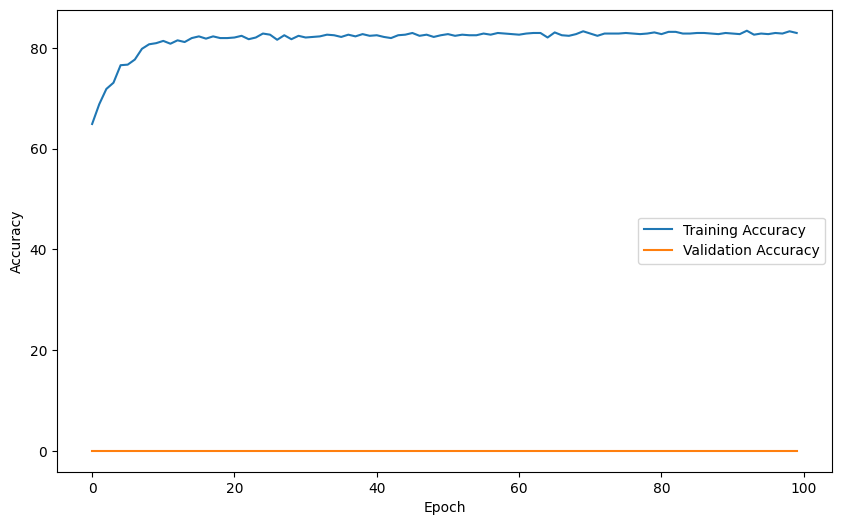

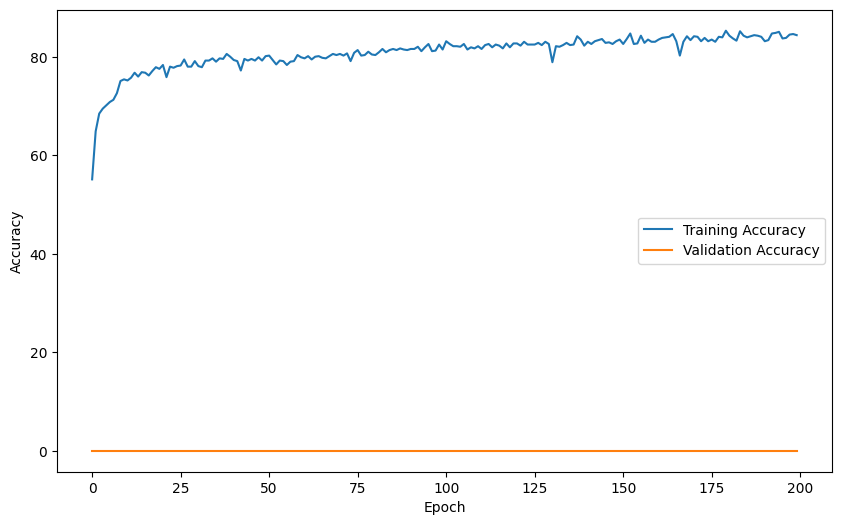

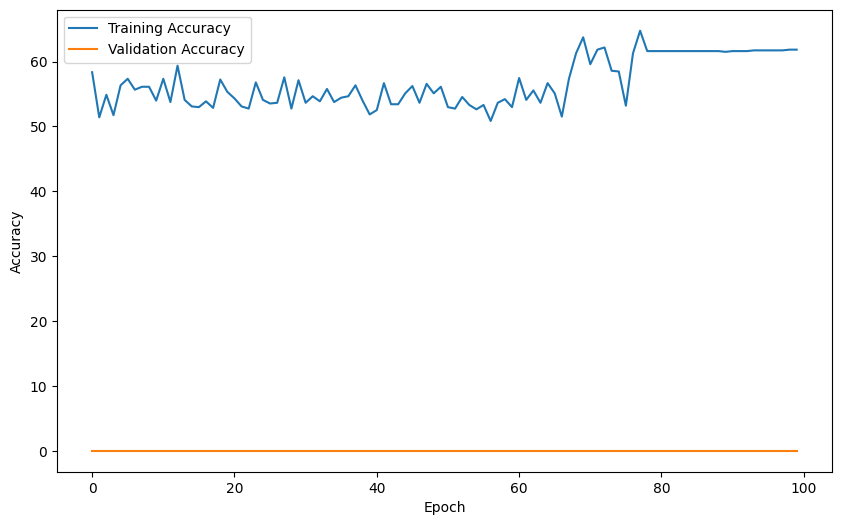

Epoch [1/100], Loss: 0.0224, Accuracy: 84.40%, Test Accuracy: 0.00
Epoch [2/100], Loss: 0.0143, Accuracy: 84.40%, Test Accuracy: 0.00
Epoch [3/100], Loss: 0.0632, Accuracy: 85.19%, Test Accuracy: 0.00
Epoch [4/100], Loss: 0.1004, Accuracy: 83.73%, Test Accuracy: 0.00
Epoch [5/100], Loss: 0.0984, Accuracy: 83.39%, Test Accuracy: 0.00
Epoch [6/100], Loss: 0.0677, Accuracy: 84.74%, Test Accuracy: 0.00
Epoch [7/100], Loss: 2.3803, Accuracy: 84.18%, Test Accuracy: 0.00
Epoch [8/100], Loss: 0.1025, Accuracy: 84.74%, Test Accuracy: 0.00
Epoch [9/100], Loss: 1.2140, Accuracy: 83.95%, Test Accuracy: 0.00
Epoch [10/100], Loss: 1.2399, Accuracy: 83.84%, Test Accuracy: 0.00
Epoch [11/100], Loss: 0.0523, Accuracy: 84.06%, Test Accuracy: 0.00
Epoch [12/100], Loss: 0.1230, Accuracy: 84.06%, Test Accuracy: 0.00
Epoch [13/100], Loss: 0.0999, Accuracy: 84.06%, Test Accuracy: 0.00
Epoch [14/100], Loss: 0.0014, Accuracy: 83.95%, Test Accuracy: 0.00
Epoch [15/100], Loss: 0.1011, Accuracy: 83.50%, Test Accu

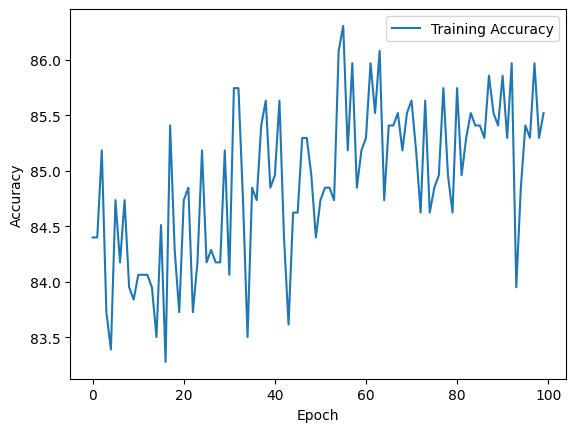

In [611]:
full_train_X_tensor = torch.tensor(X.values.astype(np.float32), dtype=torch.float32)
full_train_y_tensor = torch.tensor(y.values, dtype=torch.long)
full_train_dataset = TensorDataset(full_train_X_tensor, full_train_y_tensor)
full_train_loader = DataLoader(full_train_dataset, batch_size=10, shuffle=True)

unlabeled_X_tensor = torch.tensor(unlabeled.values.astype(np.float32), dtype=torch.float32)

split_data = split(X, location_columns, relationship_columns, personal_columns)
X_train_relationships, X_train_personal, X_train_loc, relationship_columns_indices, personal_columns_indices, location_columns_indices = split_data

relationship_model = Classifier(X_train_relationships.shape[1], 2)
personal_model = Classifier(X_train_personal.shape[1], 2)
loc_model = Classifier(X_train_loc.shape[1], 2)

relationship_dataset = TensorDataset(torch.tensor(X_train_relationships.values.astype(np.float32), dtype=torch.float32), full_train_y_tensor)
relationship_loader = DataLoader(relationship_dataset, batch_size=10, shuffle=True)
personal_dataset = TensorDataset(torch.tensor(X_train_personal.values.astype(np.float32), dtype=torch.float32), full_train_y_tensor)
personal_loader = DataLoader(personal_dataset, batch_size=10, shuffle=True)
loc_dataset = TensorDataset(torch.tensor(X_train_loc.values.astype(np.float32), dtype=torch.float32), full_train_y_tensor)
loc_loader = DataLoader(loc_dataset, batch_size=10, shuffle=True)

a_rel, b_rel = train(relationship_model, relationship_loader, None, 100)
a_pers, b_pers = train(personal_model, personal_loader, None, 250)
a_loc, b_loc = train(loc_model, loc_loader, None, 100)
plot(a_rel, b_rel)
plot(a_pers, b_pers)
plot(a_loc, b_loc)
# Train on the entire dataset
training_acc, test_acc = train(ensemble_model_new, full_train_loader, None, num_epochs=100)
plt.plot(training_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

ensemble_model_new.eval()
predictions = pd.DataFrame()
predictions['PassengerId'] = unlabeled['PassengerId']
with torch.no_grad():
    unlabeled_predictions = ensemble_model_new(unlabeled_X_tensor).argmax(dim=1)
    predictions['Survived'] = unlabeled_predictions.numpy()

predictions.to_csv('predictions.csv', index=False)
